# Preprocess data

In [1]:
import s2stools
import xarray as xr
import proplot as pplt

/project/meteo/work/Jonas.Spaeth/gitprojects/strat-impact-on-forecast-uncertainty/venv/lib/python3.11/site-packages/s2stools/clim.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
xr.set_options(display_expand_data=False)

## Re structure S2S forecast dataset

In [3]:
ds = xr.merge(
    [
        xr.open_mfdataset(
            "../data/raw/s2s-ecmwf/*z1000*.nc", preprocess=s2stools.process.s2sparser
        ).rename(gh="z1000"),
        xr.open_mfdataset(
            "../data/raw/s2s-ecmwf/*pv320k*.nc", preprocess=s2stools.process.s2sparser
        ).rename(pv="pv320k"),
    ]
)

## Compute diagnostics

### Eddy activity

In [4]:
da_pv = xr.concat(
    [
        ds.pv320k.drop_sel(hc_year=0)
        .sel(number=slice(11))
        .stack(fc=["reftime", "hc_year", "number"]),
        ds.pv320k.sel(hc_year=[0]).stack(fc=["reftime", "hc_year", "number"]),
    ],
    dim="fc",
).compute()

In [5]:
da_pv

<xarray.DataArray 'pv320k' (latitude: 10, longitude: 36, leadtime: 47, fc: 582)>
6.589e-06 6.52e-06 6.659e-06 6.588e-06 ... -1.7e-07 -3.679e-08 8.344e-08
Coordinates:
  * leadtime   (leadtime) timedelta64[ns] 0 days 1 days ... 45 days 46 days
  * longitude  (longitude) float32 -180.0 -170.0 -160.0 ... 150.0 160.0 170.0
  * latitude   (latitude) float32 90.0 80.0 70.0 60.0 ... 30.0 20.0 10.0 0.0
    validtime  (leadtime, fc) datetime64[ns] 1998-01-01 ... 2018-02-19
  * fc         (fc) object MultiIndex
  * reftime    (fc) datetime64[ns] 2018-01-01 2018-01-01 ... 2018-01-04
  * hc_year    (fc) int64 -20 -20 -20 -20 -20 -20 -20 -20 ... 0 0 0 0 0 0 0 0
  * number     (fc) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49 50
Attributes:
    units:      K m**2 kg**-1 s**-1
    long_name:  Potential vorticity

In [6]:
def compute_eddy_activity(pv_data, window_sizes):
    result = []
    for window in window_sizes:
        data_rolled = pv_data.copy(deep=True)
        for _ in range(3):
            data_rolled = data_rolled.rolling(
                leadtime=window, min_periods=1, center=True
            ).mean()
        pv_var = (pv_data - data_rolled) ** 2
        pv_var = pv_var.rename("eddy_activity").unstack().mean("number")
        result.append(pv_var)
    return xr.concat(result, dim="window_size").assign_coords(window_size=window_sizes)


eddy_activity = compute_eddy_activity(da_pv, [5, 7, 10, 14])
s2stools.process.save_one_file_per_reftime(
    eddy_activity.to_dataset(),
    "../data/processed/eddy_activity",
)

[########################################] | 100% Completed | 103.82 ms


### Ensembe mean and variance

In [7]:
z1000_ensmean = ds.z1000.mean("number").rename("z1000_ensmean").compute()
z1000_ensvar = ds.z1000.var("number", ddof=1).rename("z1000_ensvar").compute()

### Latitude of maximum meridional PV gradient

In [8]:
pv_grad = ds.pv320k.differentiate("latitude").compute()

In [9]:
pv_grad_rt = pv_grad.sel(hc_year=0)
pv_grad_hc = pv_grad.drop_sel(hc_year=0).sel(number=range(11))

idx_lat_max_pv_grad_rt = pv_grad_rt.argmax("latitude")
idx_lat_max_pv_grad_hc = pv_grad_hc.argmax("latitude")

lat_max_pv_grad = xr.concat(
    [
        pv_grad_rt.isel(latitude=idx_lat_max_pv_grad_rt).latitude,
        pv_grad_hc.isel(latitude=idx_lat_max_pv_grad_hc).latitude,
    ],
    dim="hc_year",
).rename("latitude_max_pv_grad")
lat_max_pv_grad

<xarray.DataArray 'latitude_max_pv_grad' (reftime: 2, longitude: 36,
                                          leadtime: 47, number: 51, hc_year: 21)>
40.0 60.0 90.0 60.0 30.0 40.0 40.0 40.0 40.0 ... nan nan nan nan nan nan nan nan
Coordinates:
  * leadtime   (leadtime) timedelta64[ns] 0 days 1 days ... 45 days 46 days
  * longitude  (longitude) float32 -180.0 -170.0 -160.0 ... 150.0 160.0 170.0
  * number     (number) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * reftime    (reftime) datetime64[ns] 2018-01-01 2018-01-04
  * hc_year    (hc_year) int64 0 -20 -19 -18 -17 -16 -15 ... -6 -5 -4 -3 -2 -1
    latitude   (reftime, longitude, leadtime, number, hc_year) float32 40.0 ....
    validtime  (reftime, leadtime, hc_year) datetime64[ns] 2018-01-01 ... 201...
Attributes:
    units:      degrees_north
    long_name:  latitude

/project/meteo/work/Jonas.Spaeth/gitprojects/strat-impact-on-forecast-uncertainty/venv/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/project/meteo/work/Jonas.Spaeth/gitprojects/strat-impact-on-forecast-uncertainty/venv/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/project/meteo/work/Jonas.Spaeth/gitprojects/strat-impact-on-forecast-uncertainty/venv/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self

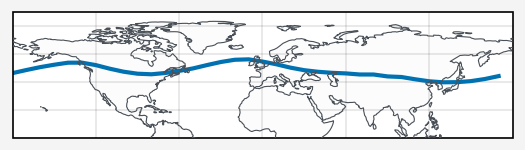

In [10]:
lat_mean = lat_max_pv_grad.mean(["reftime", "hc_year", "number", "leadtime"])

fig, ax = pplt.subplots(proj="cyl", latlim=(90, 0))
ax.plot(lat_mean.longitude, lat_mean)
s2stools.plot.add_map(ax)

## Deseasonalization

In [11]:
eddy_activity

<xarray.DataArray 'eddy_activity' (window_size: 4, latitude: 10, longitude: 36,
                                   leadtime: 47, reftime: 2, hc_year: 21)>
3.876e-12 1.009e-13 2.708e-12 4.307e-14 ... 7.079e-15 3.371e-15 6.115e-15
Coordinates:
  * reftime      (reftime) datetime64[ns] 2018-01-01 2018-01-04
  * hc_year      (hc_year) int64 -20 -19 -18 -17 -16 -15 ... -5 -4 -3 -2 -1 0
  * leadtime     (leadtime) timedelta64[ns] 0 days 1 days ... 45 days 46 days
  * longitude    (longitude) float32 -180.0 -170.0 -160.0 ... 150.0 160.0 170.0
  * latitude     (latitude) float32 90.0 80.0 70.0 60.0 ... 30.0 20.0 10.0 0.0
  * window_size  (window_size) int64 5 7 10 14

In [12]:
climatogy_settings_mean = dict(window_size=15, ndays_clim_filter=7, groupby="leadtime")
climatogy_settings_var = climatogy_settings_mean | dict(ndays_clim_filter=1)

with xr.set_options(use_flox=False):
    eddy_activity_clim = s2stools.clim.climatology(
        eddy_activity, **climatogy_settings_mean
    )
    eddy_activity_anom = (eddy_activity - eddy_activity_clim).rename(
        "eddy_activity_anom"
    )

    z1000_ensmean_clim = s2stools.clim.climatology(
        z1000_ensmean, **climatogy_settings_mean
    )
    z1000_ensmean_anom = (z1000_ensmean - z1000_ensmean_clim).rename(
        "z1000_ensmean_anom"
    )

    z1000_ensvar_clim = s2stools.clim.climatology(
        z1000_ensvar, **climatogy_settings_var
    )
    z1000_ensvar_anom = (z1000_ensvar - z1000_ensvar_clim).rename("z1000_ensvar_anom")

iterating reftimes: 100%|██████████| 2/2 [00:00<00:00, 30.75it/s]


## Save files

In [14]:
xr.merge([eddy_activity, eddy_activity_anom]).to_netcdf(
    "../data/processed/s2s_eddy_activity.nc"
)

xr.merge(
    [z1000_ensmean, z1000_ensmean_anom, z1000_ensvar, z1000_ensvar_anom]
).to_netcdf("../data/processed/s2s_z1000.nc")

lat_max_pv_grad.to_netcdf("../data/processed/s2s_lat_max_pv_grad.nc")

# Teleconnection indices

In [15]:
telcon_indices = (
    xr.merge(
        [
            xr.load_dataarray("../data/processed/era5_u_60n_10hpa.nc"),
            s2stools.indices.download_enso(),
            s2stools.indices.download_qbo(),
            *[
                phase_and_mag.compute()
                for phase_and_mag in s2stools.indices.download_mjo()
            ],
        ],
        join="inner",
    )
    .compute()
    .drop_vars(["plev", "latitude"])
)

/project/meteo/work/Jonas.Spaeth/gitprojects/strat-impact-on-forecast-uncertainty/venv/lib/python3.11/site-packages/s2stools/indices.py:35: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  return dataarray.rename(T="time").assign_coords(time=dates)
/project/meteo/work/Jonas.Spaeth/gitprojects/strat-impact-on-forecast-uncertainty/venv/lib/python3.11/site-packages/s2stools/indices.py:35: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to supp

In [16]:
telcon_indices

<xarray.Dataset>
Dimensions:      (time: 455, p: 7)
Coordinates:
  * time         (time) datetime64[ns] 1984-01-01 1984-02-01 ... 2021-11-01
  * p            (p) int64 70 50 40 30 20 15 10
Data variables:
    u_60n_10hpa  (time) float32 39.64 54.2 3.232 -1.05 ... 4.066 15.05 20.68
    enso         (time) float64 -0.8 -0.53 -0.48 -0.6 ... -0.38 -0.5 -0.78 -0.88
    u            (p, time) float64 4.5 3.2 4.0 4.9 6.5 ... -5.1 -3.4 -0.5 11.1
    mjo_phase    (time) float32 8.0 2.0 1.0 1.0 7.0 4.0 ... 2.0 8.0 2.0 4.0 1.0
    mjo_mag      (time) float32 0.5977 1.704 1.07 1.377 ... 0.7584 1.565 0.6462

In [17]:
qbo_50hpa = (
    telcon_indices.u.sel(p=50, drop=True).resample(time="1D").interpolate("linear")
)
qbo_50hpa_ew = xr.where(qbo_50hpa > 0, "W", "E").rename("qbo_50hpa_ew")
qbo_50hpa_ew

<xarray.DataArray 'qbo_50hpa_ew' (time: 13820)>
'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' ... 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W'
Coordinates:
  * time     (time) datetime64[ns] 1984-01-01 1984-01-02 ... 2021-11-01

In [18]:
telcon_indices_processed = xr.merge(
    [telcon_indices.drop_vars("u"), qbo_50hpa_ew], join="inner"
)
telcon_indices_processed

<xarray.Dataset>
Dimensions:       (time: 455, p: 7)
Coordinates:
  * time          (time) datetime64[ns] 1984-01-01 1984-02-01 ... 2021-11-01
  * p             (p) int64 70 50 40 30 20 15 10
Data variables:
    u_60n_10hpa   (time) float32 39.64 54.2 3.232 -1.05 ... 4.066 15.05 20.68
    enso          (time) float64 -0.8 -0.53 -0.48 -0.6 ... -0.5 -0.78 -0.88
    mjo_phase     (time) float32 8.0 2.0 1.0 1.0 7.0 4.0 ... 2.0 8.0 2.0 4.0 1.0
    mjo_mag       (time) float32 0.5977 1.704 1.07 1.377 ... 0.7584 1.565 0.6462
    qbo_50hpa_ew  (time) <U1 'W' 'W' 'W' 'W' 'E' 'E' ... 'W' 'W' 'W' 'W' 'W' 'W'

In [19]:
telcon_indices_processed.to_netcdf("../data/processed/telcon_indices.nc")